In [1]:
import os
from glob import glob
import numpy as np
import h5py
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scikit_posthocs import posthoc_dunn
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf
import function.utils as ut

In [2]:
# %% Setup
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': [os.path.join(folder,'Similar5_937_invivo.hdf5'),
                       os.path.join(folder,'Similar6_939_invivo.hdf5'),
                       os.path.join(folder,'Similar7_948_invivo.hdf5'),
                       os.path.join(folder,'Similar8_5454_invivo.hdf5')]}
exps = ['Enriched','Dissimilar','Similar']

## Look at one experiment

In [3]:
p = 0
datapaths = alldata[exps[p]]
day = [1,2,3]  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells
pval_thr = 0.05  # Threshold for significant spatial information
ybin = 80  # Number of spatial bins
ysigma = 1  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [4]:
# %% Load data
data_list = []
tuning_list = []
pc_list = []  # Place cells
tuning_pc_list = []

for datapath in datapaths:
    
    data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)  # cells property per day
    with h5py.File(datapath, 'r') as f:
        yrange = f['params/yrange'][()]  # Dataset dependent
        
    tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                               spike=False, transient=True)
    significant = (cells['si_pvalue'] <= pval_thr).T  # (nctx*nday, ncell)
    pc_list.append(significant)
    data_list.append(data)
    tuning_list.append(tuning)
    place_cells = np.any(significant, axis=0)
    tuning_pc_list.append([tun[place_cells] for tun in tuning])

In [5]:
# %% Place cells per day
nday = len(set(days))
for s in range(2*nday):  # Two contexts per day
    npc = sum([np.sum(pc[s]) for pc in pc_list])
    print('Day %d context %d: number of place cells %d' % (s//2+1, s%2, npc))

Day 1 context 0: number of place cells 76
Day 1 context 1: number of place cells 102
Day 2 context 0: number of place cells 61
Day 2 context 1: number of place cells 103
Day 3 context 0: number of place cells 50
Day 3 context 1: number of place cells 53


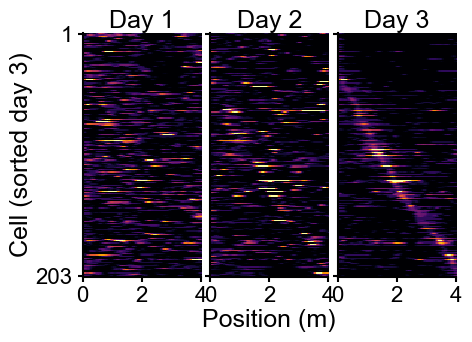

In [6]:
def display_tuning(tuning_list, days=np.array([1,1,1,1]), ctx=np.array([0,1,0,1]), c=1, sort=2):
    
    n_mice = len(tuning_list)
    nday = len(set(days))
    tuning_mean = [[] for _ in range(nday)]

    for d in range(nday):
        ks = np.where((days==(d+1)) & (ctx==c))[0]
        for m in range(n_mice):
            tuning = tuning_list[m]
            M = np.concatenate([tuning[k] for k in ks], axis=2)
            tuning_mean[d].append(M.mean(axis=2))
            
        tuning_mean[d] = np.vstack(tuning_mean[d])
    vmax = np.percentile(np.stack(tuning_mean),99.5)
    
    fig, axs = plt.subplots(1,nday,figsize=(5,3.7),sharey=True,sharex=True)  # Enriched (5,3.7) Dissimilar (5,3)
    ncell = tuning_mean[0].shape[0]
    order = ut.sort_tuning(tuning_mean[sort])[1]
    for d in range(nday):
        axs[d].imshow(tuning_mean[d][order], cmap='inferno', interpolation='none',
                      vmin=0, vmax=vmax, extent=[0,4,ncell+0.5,0.5])
    for d, ax in enumerate(axs):
        ax.set_aspect('auto')
        ax.set_title(f'Day {d+1}')
    axs[0].set(xticks=[0,2,4], xticklabels=[0,2,4], 
               yticks=[1,ncell], yticklabels=[1,ncell], ylabel='Cell (sorted day 3)')
    axs[1].set_xlabel('Position (m)')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.08)
    
    return fig
    
fig = display_tuning(tuning_pc_list, days=days, ctx=ctx, c=1, sort=2)
# fig.savefig('Tuning stability similar novel.svg')

C:\ProgramData\Anaconda3\envs\neurokit\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


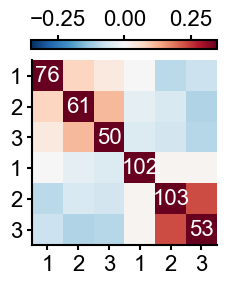

In [7]:
def cross_day_correlation(tuning_list, pc_list, days=np.array([1,1,1,1]), 
                          ctx=np.array([0,1,0,1]), grouped=True):
    nday = len(set(days))
    nctx = len(set(ctx))
    n_mice = len(tuning_list)
    pc_pool = np.hstack(pc_list)  # (ncat*nday, ncell)
    npc = np.sum(pc_pool, axis=1)
    tuning_day = [[] for _ in range(nday)]
    
    for d, dd in enumerate(list(dict.fromkeys(days))):  # Unique element and preserve order
        for c in range(nctx):
            ks = np.where((days==dd) & (ctx==c))[0]
            tuning = [[] for _ in range(n_mice)]
            for m in range(n_mice):
                tuning[m] = np.concatenate([tuning_list[m][k] for k in ks], axis=2).mean(axis=2)
            tuning_day[d].append(np.vstack(tuning))
    
    cross_corr = np.ones((nday*2,)*2)
    for d1 in range(nday*2):
        c1 = d1 % 2
        # pc = np.where(si_pvalue[d1] <= pval_thr)[0]  # Asymetric versus (d1,d2)
        for d2 in np.setdiff1d(range(nday*2), d1):
            c2 = d2 % 2
            pc = np.where(pc_pool[d1] | pc_pool[d2])[0]
            cross_corr[d1,d2] = np.nanmedian(  # nanmean
                [stats.pearsonr(tuning_day[d1//2][c1][i],
                                tuning_day[d2//2][c2][i])[0] for i in pc])
    vmax = np.max(cross_corr[np.triu_indices(nday*2, k=1)])
    vmax = np.ceil((vmax+0.1)*20)/20
    labels = np.repeat(np.arange(1,nday+1),2)  # Days
    
    ## Plot
    fig, ax = plt.subplots(figsize=(2.4,3))
    ax.set(xticks=range(1,nday*2+1), yticks=range(1,nday*2+1))
    if grouped:
        order = np.hstack([np.arange(nday*2)[::2], np.arange(nday*2)[1::2]])
        img = ax.imshow(cross_corr[order][:,order], cmap='RdBu_r', vmin=-vmax, vmax=vmax,
                        extent=[0.5,nday*2+0.5,nday*2+0.5,0.5])
        for i, n in enumerate(npc[order]):
            ax.text(i+1, i+1, str(n), ha='center', va='center', c='w')
            ax.set(xticklabels=labels[order], yticklabels=labels[order])
    else:
        img = ax.imshow(cross_corr, cmap='RdBu_r', vmin=-vmax, vmax=vmax,
                        extent=[0.5,nday*2+0.5,nday*2+0.5,0.5])
        for i, n in enumerate(npc):
            ax.text(i+1, i+1, str(n), ha='center', va='center', c='w')
        ax.set(xticklabels=labels, yticklabels=labels)
    fig.colorbar(img, ax=ax, location='top')
    
    return fig

fig = cross_day_correlation(tuning_list, pc_list, days=days, ctx=ctx, grouped=True)
# fig.savefig('Cross day correlation dissimilar.svg')

## Functions

In [8]:
def analyze_stability(tuning_list, pc_list, days=np.array([1,1,1,1]), ctx=np.array([0,1,0,1])):
    
    n_mice = len(tuning_list)
    nctx = len(set(ctx))
    nday = len(set(days))
    
    tuning_day = [[] for _ in range(nday)]
    for d, dd in enumerate(list(dict.fromkeys(days))):  # Unique element and preserve order
        for c in range(nctx):
            ks = np.where((days==dd) & (ctx==c))[0]
            tuning = [[] for _ in range(n_mice)]
            for m in range(n_mice):
                tuning[m] = np.concatenate([tuning_list[m][k] for k in ks], axis=2).mean(axis=2)
            tuning_day[d].append(np.vstack(tuning))
            
    R_day = [[] for _ in range(nday-1)]  # Days 1-2, 2-3, ...
    for d in range(nday-1):
        s0 = 2*d + 1  # 1st Nov session
        s1 = 2*(d+1) + 1  # 2nd Nov session
        place_cells = np.where(np.hstack([(pc[s0] | pc[s1]) for pc in pc_list]))[0]
        R_day[d] = np.array([stats.pearsonr(tuning_day[d][1][i],
                                            tuning_day[d+1][1][i])[0] for i in place_cells])
        R_day[d] = R_day[d][~np.isnan(R_day[d])]
        
    return R_day  # List (two days) of cells

In [9]:
def analyze_remapping(tuning_list, pc_list, days=np.array([1,1,1,1]), ctx=np.array([0,1,0,1])):
    
    n_mice = len(tuning_list)
    nctx = len(set(ctx))
    nday = len(set(days))
    
    tuning_day = [[] for _ in range(nday)]
    tuning_fam = [[] for _ in range(nday)]
    tuning_nov = [[] for _ in range(nday)]
    for d, dd in enumerate(list(dict.fromkeys(days))):  # Unique element and preserve order
        s0 = 2*d  # Fam
        s1 = 2*d+1  # Nov
        for c in range(nctx):
            ks = np.where((days==dd) & (ctx==c))[0]
            tuning = [[] for _ in range(n_mice)]  # All
            tuning0 = [[] for _ in range(n_mice)]  # Even
            tuning1 = [[] for _ in range(n_mice)]  # Odd
            for m in range(n_mice):
                place_cells = np.where((pc_list[m][s0]) | (pc_list[m][s1]))[0]
                M = np.concatenate([tuning_list[m][k][place_cells] for k in ks], axis=2)
                tuning[m] = M.mean(axis=2)
                tuning0[m] = M[:,:,0::2].mean(axis=2)  # Average even trials
                tuning1[m] = M[:,:,1::2].mean(axis=2)  # Average odd trials
            tuning_day[d].append(np.vstack(tuning))
            if c == 0:  # Fam even/odd
                tuning_fam[d] = [np.vstack(tuning0), np.vstack(tuning1)]
            elif c == 1:  # Nov even/odd
                tuning_nov[d] = [np.vstack(tuning0), np.vstack(tuning1)]
    
    R_remapping = [[] for _ in range(nday)]
    for d in range(nday):
        R_ff = np.array([stats.pearsonr(a, b)[0] for a, b in zip(tuning_fam[d][0], tuning_fam[d][1])])
        R_nn = np.array([stats.pearsonr(a, b)[0] for a, b in zip(tuning_nov[d][0], tuning_nov[d][1])])
        R_fn = np.array([stats.pearsonr(a, b)[0] for a, b in zip(tuning_day[d][0], tuning_day[d][1])])
        R_remapping[d] = np.vstack([R_ff,R_nn,R_fn])
    
    return R_remapping  # List (day) of (3,ncell)

## Run for all datasets

In [10]:
day = [1,2,3]
min_rate = 1/60
pval_thr = 0.05
ybin = 80
ysigma = 1

R_stability = []
R_remapping = []

for p, exp in enumerate(exps):
    print('Get %s datasets ...' % exp)
    tuning_list = []
    pc_list = []  # Place cells
    
    for datapath in alldata[exp]:
        data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
        with h5py.File(datapath, 'r') as f:
            yrange = f['params/yrange'][()]  # Dataset dependent
            
        tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                                   spike=False, transient=True)
        significant = (cells['si_pvalue'] <= pval_thr).T  # (nctx*nday, ncell)
        
        pc_list.append(significant)
        tuning_list.append(tuning)
    
    R_stability.append(
        analyze_stability(tuning_list, pc_list, days=days, ctx=ctx))
    R_remapping.append(
        analyze_remapping(tuning_list, pc_list, days=days, ctx=ctx))

Get Enriched datasets ...
Get Dissimilar datasets ...
Get Similar datasets ...


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Dissimilar_D1-2 vs. Dissimilar_D2-3: Mann-Whitney-Wilcoxon test two-sided, P_val:4.709e-02 U_stat=1.658e+03
Enriched_D1-2 vs. Enriched_D2-3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.155e-04 U_stat=6.975e+03
Similar_D1-2 vs. Similar_D2-3: Mann-Whitney-Wilcoxon test two-sided, P_val:5.373e-01 U_stat=6.790e+02


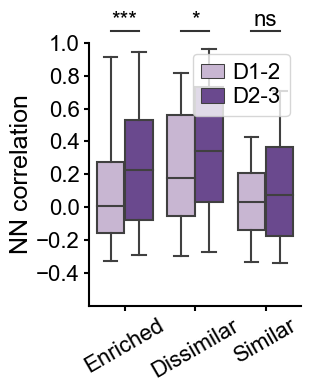

In [20]:
## Place field correlation between days in novel context
fig, ax = plt.subplots(figsize=(3.4,4.2))
ut.compare_grouped(R_stability, varnames=['Experiment','Context','Correlation'],
                   varvalues=(exps,['D1-2','D2-3'],None), palette=[plt.cm.Paired(8),plt.cm.Paired(9)],  # ['tab:olive','tab:green']
                   kind='box', test='Mann-Whitney', fig=fig, ax=ax, whis=(1,99), showfliers=False)
ax.set(ylim=[-0.6,1], yticks=np.linspace(-0.4,1,8))
ax.set_xticklabels(exps, rotation=30)
ax.set(xlabel='', ylabel='NN correlation')
fig.tight_layout()
fig.savefig('Place field stability.svg')

Kruskal-Wallis test, p-value: 0.7148
Post-hoc Dunn's test
1 vs 2 p-value: 1
1 vs 3 p-value: 1
2 vs 3 p-value: 1
--------------------------------
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

1 vs. 2: Custom statistical test, P_val:1.000e+00
2 vs. 3: Custom statistical test, P_val:1.000e+00
1 vs. 3: Custom statistical test, P_val:1.000e+00


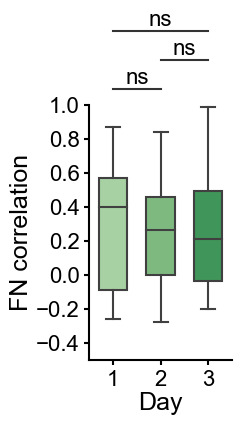

In [25]:
## Fam/Nov correlation along days
def summary_multiple(Remapping, days=[1,2,3], colors=['C0','C1','C2']):
    
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    nday = len(days)
    # remapping = [np.nanmean(R[0:2,:], axis=0)-R[2] for R in Remapping]  # mean(FF,NN)-FN
    remapping = [R[2] for R in Remapping]  # Correlation Fam/Nov
    
    df = pd.DataFrame({'Correlation': np.hstack(remapping),
                       'Day': np.hstack([np.repeat(str(days[d]), len(remapping[d]))
                                                for d in range(nday)])})
    
    fig, ax = plt.subplots(figsize=(2.7,4.5))
    sns.boxplot(data=df, x='Day', y='Correlation', ax=ax, width=0.6, palette=colors, whis=(1,99), showfliers=False)
    
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    pairs, pvalues = [], []
    
    stat, pval = stats.kruskal(*remapping, nan_policy='omit')
    print('Kruskal-Wallis test, p-value: %.4g' % pval)
    pval_paired = posthoc_dunn(remapping, p_adjust='bonferroni').to_numpy()  # bonferroni, sidak, fdr_bh
    print('Post-hoc Dunn\'s test')
    for u, v in zip([0,0,1],[1,2,2]):
        pairs.append((str(days[u]), str(days[v])))
        pvalues.append(pval_paired[u,v])
        print(f'{days[u]} vs {days[v]} p-value: {pval_paired[u,v]:.4g}')
    print('-'*32)
    
    annot = Annotator(ax, pairs, data=df, x='Day', y='Correlation')
    annot.configure(test=None, loc='outside', line_width=lwidth, line_height=0., pvalue_format=pformat)
    annot.set_pvalues(pvalues)
    annot.annotate()
    
    # ax.set_xticklabels(days, rotation=30)
    ax.set(xlabel='', ylabel='Correlation FN')
    fig.tight_layout()
    
    return fig, ax

p = 2
colors = [plt.cm.tab20c(i) for i in [10,9,8]]
fig, ax = summary_multiple(R_remapping[p], days=[1,2,3], colors=colors)
ax.set(ylim=[-0.5,1], yticks=np.linspace(-0.4,1,8))
ax.set(xlabel='Day', ylabel='FN correlation')
fig.savefig('Similar discrimination.svg')

C:\Users\Hung-Ling\AppData\Local\Temp\ipykernel_8568\3343081258.py:20: RuntimeWarning: Mean of empty slice
  R = np.nanmean(R_remapping[p][d][0:2,:], axis=0) - R_remapping[p][d][2]  # mean(FF,NN)-FN


-------- Day 1 --------
Kruskal-Wallis test, p-value: 1.082e-06
Post-hoc Dunn's test
Enriched vs Dissimilar p-value: 1
Enriched vs Similar p-value: 1.688e-06
Dissimilar vs Similar p-value: 6.955e-05
--------------------------------
-------- Day 2 --------
Kruskal-Wallis test, p-value: 1.509e-05
Post-hoc Dunn's test
Enriched vs Dissimilar p-value: 0.7537
Enriched vs Similar p-value: 1.589e-05
Dissimilar vs Similar p-value: 0.002838
--------------------------------
-------- Day 3 --------
Kruskal-Wallis test, p-value: 1.152e-05
Post-hoc Dunn's test
Enriched vs Dissimilar p-value: 1
Enriched vs Similar p-value: 6.399e-05
Dissimilar vs Similar p-value: 0.0004315
--------------------------------
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

2_Dissimilar vs. 2_Similar: Custom statistical test, P_val:2.838e-03
3_Enriched vs. 3_Dissimilar: Custom statistical test, P_val:1.000e+00
3_Dissimilar vs

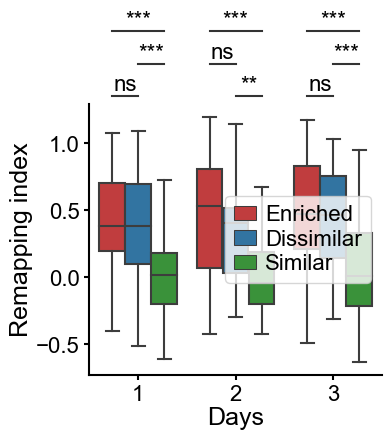

In [12]:
## Plot remapping indices (i.e. correlation (FF+NN)/2-FN) along days and experiments
## R_remapping: list (of experiments) of list (of days) of 3-by-n array (FF/NN/FN correlations)
def summary_exps_days(R_remapping, exps=['Enriched','Dissimilar','Similar'], days=[1,2,3], 
                      colors=['tab:red','tab:blue','tab:green'], fig=None, ax=None):
    
    fsize = plt.rcParams['font.size']
    lwidth = plt.rcParams['axes.linewidth']
    if fig is None:
        fig = plt.figure(figsize=(3,4))
    if ax is None:
        ax = plt.gca()
    
    nexp = len(exps)
    nday = len(days)
    remapping = [[] for _ in range(nday)]  # list (of days) of list (of experiments) of remapping indices
    experiment, day = [], []
    for d in range(nday):
        for p in range(nexp):
            # R = R_remapping[p][d][2]  # FN correlations
            R = np.nanmean(R_remapping[p][d][0:2,:], axis=0) - R_remapping[p][d][2]  # mean(FF,NN)-FN
            remapping[d].append(R)
            experiment.append(np.repeat(exps[p], len(R)))
            day.append(np.repeat(str(days[d]), len(R)))
    
    df = pd.DataFrame({'Correlation': np.hstack([np.hstack(R) for R in remapping]),
                       'Experiment': np.hstack(experiment),
                       'Day': np.hstack(day)})
    
    sns.boxplot(data=df, x='Day', y='Correlation', hue='Experiment', ax=ax, width=0.8, 
                palette=colors, whis=(1,99), showfliers=False)
    
    pformat = {'pvalue_thresholds':[[1e-3,'***'],[1e-2,'**'],[0.05,'*'],[1,'ns']], 'fontsize':fsize}
    pairs, pvalues = [], []
    for d in range(nday):
        print('-------- Day %d --------' % (d+1))
        stat, pval = stats.kruskal(*remapping[d], nan_policy='omit')
        print('Kruskal-Wallis test, p-value: %.4g' % pval)
        pval_paired = posthoc_dunn(remapping[d], p_adjust='bonferroni').to_numpy()  # bonferroni, sidak, fdr_bh
        print('Post-hoc Dunn\'s test')
        for u, v in zip([0,0,1],[1,2,2]):
            pairs.append(((str(days[d]), exps[u]), (str(days[d]), exps[v])))
            pvalues.append(pval_paired[u,v])
            print(f'{exps[u]} vs {exps[v]} p-value: {pval_paired[u,v]:.4g}')
        print('-'*32)
    
    annot = Annotator(ax, pairs, data=df, x='Day', y='Correlation', hue='Experiment')
    annot.configure(test=None, loc='outside', line_width=lwidth, line_height=0., pvalue_format=pformat)
    annot.set_pvalues(pvalues)
    annot.annotate()
    
    # ax.set_xticklabels(exps, rotation=30)
    ax.set(xlabel='Days', ylabel='Remapping index')
    fig.tight_layout()
    
    return fig, ax

fig, ax = plt.subplots(figsize=(4.2,4.6))
fig, ax = summary_exps_days(R_remapping, fig=fig, ax=ax)
ax.legend()
fig.tight_layout()
# fig.savefig('Remapping exps days.svg')